In [1]:
import sys
# setting path
sys.path.append('../')

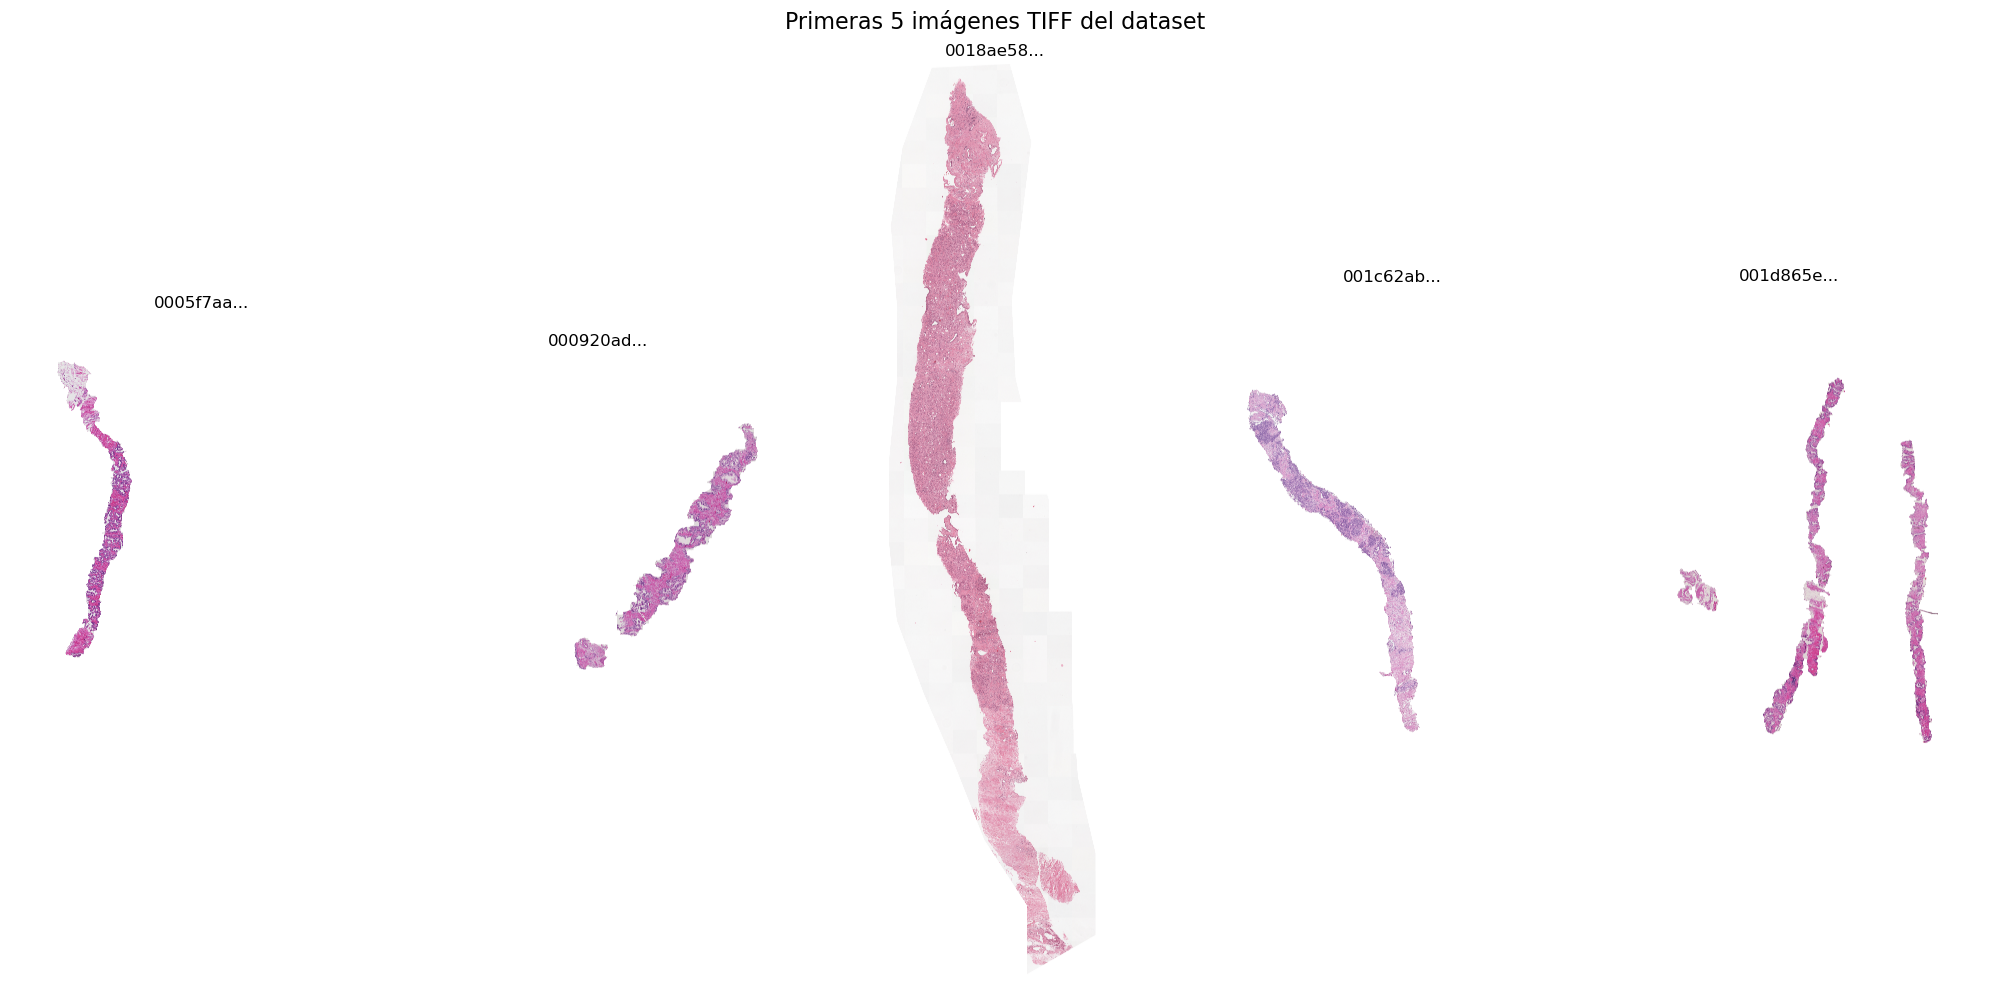

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta a las imágenes .tiff
TIFF_DIR = "/data/datasets/PANDA/PANDA_original/original/train_images"

# Listar los primeros 5 archivos .tiff del directorio
tiff_files = sorted([f for f in os.listdir(TIFF_DIR) if f.endswith(".tiff")])[:5]
assert len(tiff_files) >= 5, f"Se encontraron solo {len(tiff_files)} archivos TIFF"

# Mostrar cada imagen
plt.figure(figsize=(20, 10))
for i, filename in enumerate(tiff_files):
    img_path = os.path.join(TIFF_DIR, filename)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(filename[:8] + "...")

plt.suptitle("Primeras 5 imágenes TIFF del dataset", fontsize=16)
plt.tight_layout()
plt.show()


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/tmp/ipykernel_29104/2806836566.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipp

Modelo MIL cargado exitosamente desde: /home/javitrucas/TFG/notebooks/models/panda/model_attention.pth
Capa de proyección de características creada: 2048 -> 1024
Features cargadas: torch.Size([128, 2048]) para 0005f7aaab2800f6170c399693a96917
Coordenadas cargadas: (128, 2) para 0005f7aaab2800f6170c399693a96917
Calculando pesos de atención para 128 parches...
Atención calculada. Total de parches: 128

Visualizando WSI: 0005f7aaab2800f6170c399693a96917
Predicción (probabilidad de ser positivo): 0.2993
Etiqueta real (ISUP Grade): 0
Thumbnail de WSI cargado (1728x1840 píxeles).
Heatmap guardado en: /home/javitrucas/TFG/results/panda_heatmaps/0005f7aaab2800f6170c399693a96917_heatmap.png


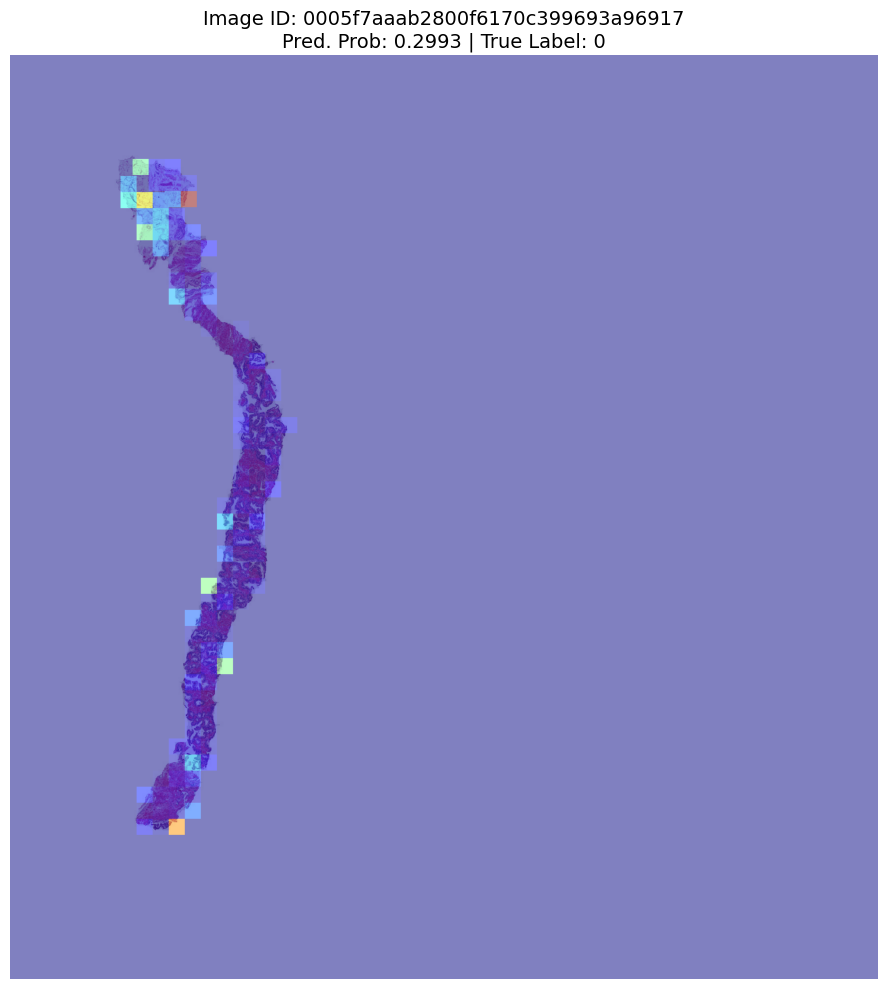


Proceso de visualización de WSI completado.


In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
import openslide # Crucial for WSI
from argparse import Namespace # Para config object
import torch.nn as nn # Necesario para nn.Linear
import h5py # Para leer archivos .h5

# Aumentar límite de PIL para imágenes grandes
Image.MAX_IMAGE_PIXELS = None

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.model import MILModel
    from scripts.plot_utils import plot_wsi_and_heatmap, normalize
    # Asegúrate de que dataset_loader y MIL_utils están disponibles si los usas en otras partes
    from scripts.dataset_loader import load_dataset
    from scripts.MIL_utils import MIL_collate_fn
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    print(f"Current sys.path: {sys.path}")
    sys.exit()

# --- Configuración de guardado y paths ---
SAVE = True
SAVE_PATH = '/home/javitrucas/TFG/results/panda_heatmaps/'
FIGSIZE = (10, 10)
SAVE_EXTENSION = 'png'
os.makedirs(SAVE_PATH, exist_ok=True)
plt.rcParams.update({'font.size': 20})

DATA_DIR = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth' 

# --- Parámetros de Extracción y Modelo ---
PATCH_SIZE = 512
RESIZE_SIZE = 112 
MAX_PATCHES = 2000 # Límite superior de parches a procesar por WSI, si hay más en el archivo .npy
INPUT_FEATURE_DIM_ACTUAL = 2048 # Dimensión REAL de tus características cargadas (2048)
INPUT_FEATURE_DIM_MODEL_EXPECTS = 1024 # Dimensión que tu modelo guardado espera (1024)
FEATURE_DIM = 128 # Dimensión interna del modelo MIL

# --- Parámetros de Visualización Específicos ---
WSI_LEVEL_FOR_THUMBNAIL = 2 # Nivel de downsampling para el thumbnail de la WSI
# Asegúrate de que esta ID de imagen existe y tiene archivos de características y coordenadas
WSI_TO_VISUALIZE_ID = '0005f7aaab2800f6170c399693a96917' 

# --- PATHS REALES PARA FEATURES Y COORDENADAS ---
# Estas rutas son CRÍTICAS y fueron determinadas en los pasos anteriores
PANDA_FEATURES_ROOT = '/data/datasets/PANDA/PANDA_original/patches_512_preset/features_resnet50/'
PANDA_COORDS_ROOT = '/data/datasets/PANDA/PANDA_original/patches_512_preset/coords/'

# --- 1. CARGAR MODELO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancia el modelo MIL con la dimensión que *espera* (1024)
model = MILModel(
    pooling_type='attention', 
    input_feature_dim=INPUT_FEATURE_DIM_MODEL_EXPECTS, # Se inicializa con la dimensión esperada por el modelo guardado
    feature_dim=FEATURE_DIM
)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo MIL cargado exitosamente desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo del modelo en la ruta especificada: {MODEL_PATH}")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el estado del modelo: {e}")
    sys.exit()

# --- Capa de proyección para adaptar las características ---
# Esta capa se creará aquí en el script y no será parte del modelo MIL
feature_projector = nn.Linear(INPUT_FEATURE_DIM_ACTUAL, INPUT_FEATURE_DIM_MODEL_EXPECTS).to(device)
print(f"Capa de proyección de características creada: {INPUT_FEATURE_DIM_ACTUAL} -> {INPUT_FEATURE_DIM_MODEL_EXPECTS}")

# --- 2. PREPARAR DATOS PARA LA WSI ESPECÍFICA ---

# Construir la ruta al archivo .tiff de la WSI
wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_TO_VISUALIZE_ID}.tiff")
if not os.path.exists(wsi_path):
    print(f"ERROR: WSI no encontrada en la ruta: {wsi_path}")
    sys.exit()

# Cargar las features para la WSI específica
features_file_path = os.path.join(PANDA_FEATURES_ROOT, f"{WSI_TO_VISUALIZE_ID}.npy")
if not os.path.exists(features_file_path):
    print(f"ERROR: Archivo de features no encontrado para {WSI_TO_VISUALIZE_ID} en {features_file_path}")
    print("Asegúrate de que tus features están pre-extraídas y guardadas en esta estructura.")
    sys.exit()

try:
    all_features_np = np.load(features_file_path)
    
    if all_features_np.shape[1] != INPUT_FEATURE_DIM_ACTUAL:
        print(f"ADVERTENCIA: La dimensión de la feature cargada ({all_features_np.shape[1]}) es diferente de INPUT_FEATURE_DIM_ACTUAL ({INPUT_FEATURE_DIM_ACTUAL}).")
        print("Esto no debería ocurrir si tus features son 2048D.")
        sys.exit() 
    
    if all_features_np.shape[0] > MAX_PATCHES:
        print(f"Advertencia: Reduciendo el número de parches de {all_features_np.shape[0]} a {MAX_PATCHES} (según MAX_PATCHES).")
        all_features_np = all_features_np[:MAX_PATCHES]

    features_tensor = torch.from_numpy(all_features_np).float().to(device)
    print(f"Features cargadas: {features_tensor.shape} para {WSI_TO_VISUALIZE_ID}")

except Exception as e:
    print(f"ERROR al cargar o procesar el archivo de features {features_file_path}: {e}")
    sys.exit()

# Cargar las coordenadas para la WSI específica (USANDO H5PY)
coords_file_path = os.path.join(PANDA_COORDS_ROOT, f"{WSI_TO_VISUALIZE_ID}.h5") 
if not os.path.exists(coords_file_path):
    print(f"ERROR: Archivo de coordenadas no encontrado para {WSI_TO_VISUALIZE_ID} en {coords_file_path}")
    sys.exit()

try:
    with h5py.File(coords_file_path, 'r') as f:
        # Asume que las coordenadas están en un dataset llamado 'coords' o similar
        if 'coords' in f: 
            all_coords = f['coords'][:] 
        else:
            print(f"ERROR: No se encontró el dataset 'coords' en el archivo HDF5 {coords_file_path}. "
                  "Por favor, revisa el contenido del archivo .h5 y actualiza el nombre del dataset.")
            print(f"Datasets disponibles en {coords_file_path}: {list(f.keys())}")
            sys.exit()

    if all_coords.shape[0] != features_tensor.shape[0]:
        print(f"Advertencia: El número de coordenadas ({all_coords.shape[0]}) no coincide con el número de features ({features_tensor.shape[0]}). Ajustando.")
        all_coords = all_coords[:features_tensor.shape[0]] 
    print(f"Coordenadas cargadas: {all_coords.shape} para {WSI_TO_VISUALIZE_ID}")
except Exception as e:
    print(f"ERROR al cargar o procesar el archivo de coordenadas {coords_file_path}: {e}")
    sys.exit()


# --- 3. OBTENER PESOS DE ATENCIÓN ---
print(f"Calculando pesos de atención para {features_tensor.shape[0]} parches...")
with torch.no_grad():
    # Proyectar las características antes de pasarlas al modelo
    projected_features = feature_projector(features_tensor) 
    bag_tensor_for_model = projected_features.unsqueeze(0) 
    
    prediction, attention_weights = model(bag_tensor_for_model)
    
    attention_weights = attention_weights.squeeze(0).cpu().numpy() 
    prediction_prob = torch.sigmoid(prediction).item()

print(f"Atención calculada. Total de parches: {len(attention_weights)}")

# Normalizar los pesos de atención
normalized_attention = normalize(attention_weights)

# --- 4. CARGAR WSI Y VISUALIZAR ---
print(f"\nVisualizando WSI: {WSI_TO_VISUALIZE_ID}")
print(f"Predicción (probabilidad de ser positivo): {prediction_prob:.4f}")

# Cargar la etiqueta real (ISUP Grade) desde train.csv
true_label_wsi = "N/A (Cargando...)"
try:
    df_train = pd.read_csv(CSV_PATH)
    true_label_wsi = df_train[df_train['image_id'] == WSI_TO_VISUALIZE_ID]['isup_grade'].values[0]
    print(f"Etiqueta real (ISUP Grade): {true_label_wsi}")
except Exception as e:
    print(f"Advertencia: No se pudo cargar la etiqueta real desde {CSV_PATH}: {e}")
    print("Asegúrate de que 'image_id' y 'isup_grade' existen en tu CSV.")


# Cargar la WSI para obtener un thumbnail
try:
    slide = openslide.OpenSlide(wsi_path)
    
    thumbnail_dims = slide.level_dimensions[WSI_LEVEL_FOR_THUMBNAIL]
    thumbnail_w, thumbnail_h = thumbnail_dims
    
    wsi_thumbnail = slide.read_region((0, 0), WSI_LEVEL_FOR_THUMBNAIL, thumbnail_dims)
    wsi_thumbnail = np.array(wsi_thumbnail)[:, :, :3] 
    
    # Obtener el factor de downsampling *antes* de cerrar el slide
    downsample_factor = slide.level_downsamples[WSI_LEVEL_FOR_THUMBNAIL] 
    
    slide.close() # Ahora es seguro cerrar el slide aquí
    print(f"Thumbnail de WSI cargado ({wsi_thumbnail.shape[1]}x{wsi_thumbnail.shape[0]} píxeles).")

except Exception as e:
    print(f"ERROR: No se pudo cargar la WSI thumbnail con openslide: {e}")
    sys.exit()

if len(all_coords) != len(normalized_attention):
    print("CRÍTICO: El número de coordenadas y scores de atención NO COINCIDE después del preprocesamiento. "
          "El heatmap será incorrecto.")
    sys.exit()

# Llamar a tu función plot_wsi_and_heatmap
plot_wsi_and_heatmap(
    wsi_image=wsi_thumbnail, 
    attention_scores=normalized_attention,
    patch_coords=all_coords, 
    patch_size=PATCH_SIZE,    
    level_downsample_factor=downsample_factor, 
    image_id=WSI_TO_VISUALIZE_ID,
    pred_prob=prediction_prob,
    true_label=true_label_wsi,
    save_path=SAVE_PATH if SAVE else None,
    save_extension=SAVE_EXTENSION
)

print("\nProceso de visualización de WSI completado.")

In [5]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
from scripts.model import MILModel
from scripts.plot_utils import plot_wsi_and_heatmap, normalize  # Uso de plot_utils para visualización

# Aumentar límite de PIL para imágenes grandes
Image.MAX_IMAGE_PIXELS = None

# Configuración para guardar figuras
SAVE = True
SAVE_PATH = '/home/javitrucas/TFG/results/panda_heatmaps/'
FIGSIZE = (10, 10)
SAVE_EXTENSION = 'png'
os.makedirs(SAVE_PATH, exist_ok=True)
plt.rcParams.update({'font.size': 20})

# Paths de datos y modelo
DATA_DIR = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth'

# Parámetros
PATCH_SIZE = 512
RESIZE_SIZE = 112
MAX_PATCHES = 2000

# Funciones auxiliares faltantes
def load_image_safely(image_path, max_dimension=4096):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            scale_factor = 1.0
            if max(width, height) > max_dimension:
                scale_factor = max_dimension / max(width, height)
                img = img.resize((int(width*scale_factor), int(height*scale_factor)), Image.Resampling.LANCZOS)
            return np.array(img), scale_factor
    except Exception as e:
        print(f"Error cargando imagen: {e}")
        return None, 0


def extract_patches_from_wsi(image_path, patch_size=512, max_patches=2000):
    image_array, scale_factor = load_image_safely(image_path, max_dimension=6144)
    if image_array is None: return [], np.array([]), 0
    h, w = image_array.shape[:2]
    adj_size = max(64, int(patch_size * scale_factor))
    step = adj_size // 2
    ys = list(range(0, h - adj_size, step))
    xs = list(range(0, w - adj_size, step))
    # Submuestreo
    if len(ys)*len(xs) > max_patches:
        sq = int(np.sqrt(max_patches))
        ys = ys[::max(1, len(ys)//sq)]
        xs = xs[::max(1, len(xs)//sq)]
    patches, coords = [], []
    for y in ys:
        for x in xs:
            if len(patches) >= max_patches: break
            patch = image_array[y:y+adj_size, x:x+adj_size]
            if patch.shape[:2] != (adj_size, adj_size): continue
            if patch.mean() > 230: continue
            gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            if np.std(gray) < 5: continue
            patches.append(patch); coords.append([x, y])
        if len(patches) >= max_patches: break
    if len(patches) < 5:
        # Relajar filtros
        patches, coords = [], []
        for y in ys:
            for x in xs:
                if len(patches) >= max_patches: break
                patch = image_array[y:y+adj_size, x:x+adj_size]
                if patch.shape[:2] == (adj_size, adj_size):
                    patches.append(patch); coords.append([x, y])
            if len(patches) >= max_patches: break
    return patches, np.array(coords), adj_size


def create_canvas_from_patches(patches, coords, patch_size, resize_size=256):
    if len(patches) == 0: return np.zeros((512,512,3),dtype=np.uint8)+255, np.array([])
    # Normalizar coords a grilla
    coords_norm = coords.copy()
    if len(coords)>1:
        xs = np.unique(np.diff(np.sort(coords[:,0]))); ys = np.unique(np.diff(np.sort(coords[:,1])))
        step_x = xs[xs>0][0] if len(xs[xs>0])>0 else patch_size
        step_y = ys[ys>0][0] if len(ys[ys>0])>0 else patch_size
        coords_norm[:,0] = coords[:,0]//step_x; coords_norm[:,1] = coords[:,1]//step_y
    else:
        coords_norm = np.array([[0,0]])
    # Ajustar índices a 0
    coords_norm -= coords_norm.min(axis=0)
    max_x, max_y = coords_norm.max(axis=0)
    width = (max_x+1)*resize_size; height = (max_y+1)*resize_size
    canvas = np.ones((height, width,3),dtype=np.uint8)*255
    for i, patch in enumerate(patches):
        col,row = coords_norm[i]; y=row*resize_size; x=col*resize_size
        p = cv2.resize(patch,(resize_size,resize_size))
        canvas[y:y+resize_size, x:x+resize_size] = p
    # Cambiar a formato row,col
    coords_rc = coords_norm[:,[1,0]]
    return canvas, coords_rc

/tmp/ipykernel_2420392/1317814527.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


WSI: 39e0f864a25b0498bf35d6d27e36d4f3, Clase predicha: 0


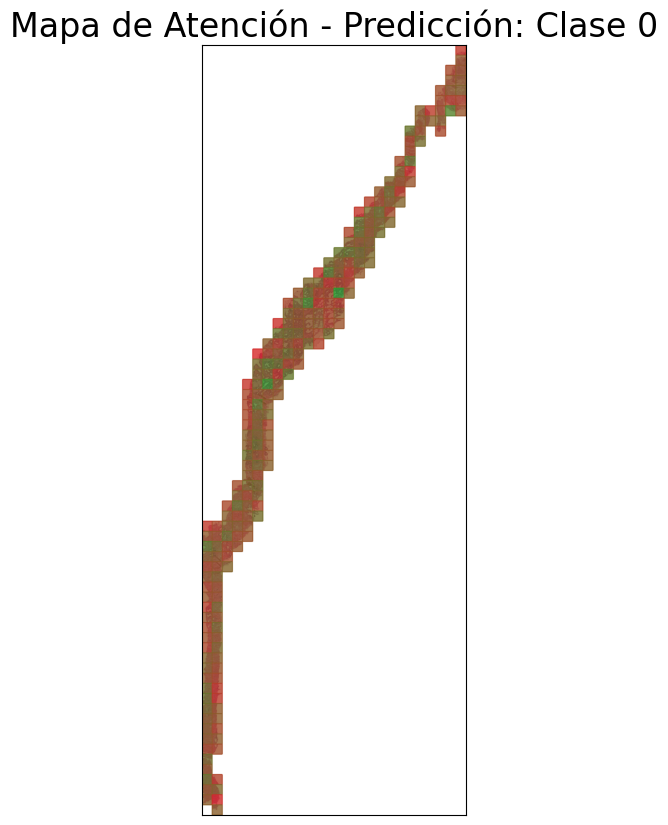

In [8]:

# ------------------ Selección de la WSI ------------------
df = pd.read_csv(CSV_PATH)
pos = df[df['isup_grade'] > 0]
sel = pos.sample(1).iloc[0] if len(pos) > 0 else df.iloc[0]
WSI_NAME = sel['image_id']
wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")

# --------------- Extracción de parches ------------------
patches, coords_xy, psize = extract_patches_from_wsi(
    wsi_path,
    patch_size=PATCH_SIZE,
    max_patches=MAX_PATCHES
)
canvas, coords_rc = create_canvas_from_patches(
    patches,
    coords_xy,
    psize,
    RESIZE_SIZE
)

# -------------- Preparación del batch -------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_list = []
for p in patches:
    pr = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
    gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
    pn = gray.astype(np.float32) / 255.0
    t_list.append(torch.FloatTensor(pn).unsqueeze(0))  # (1, H, W)

batch = torch.stack(t_list).unsqueeze(0).to(device)  # (1, N, 1, H, W)

# ------------------ Carga del modelo --------------------
model = MILModel()
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

# ------------------ Inferencia --------------------------
with torch.no_grad():
    y_pred, att = model(batch)  # y_pred.shape = (1, C), att.shape = (1, N, 1)

# ------------------ Visualización -----------------------
predicted_class = torch.argmax(y_pred, dim=1).item()
print(f"WSI: {WSI_NAME}, Clase predicha: {predicted_class}")

w = att.squeeze().cpu().numpy()  # shape (N,)
w_norm = normalize(w)

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_wsi_and_heatmap(
    ax,
    canvas,
    attval=w_norm,
    plot_patch_contour=True,
    size=RESIZE_SIZE,
    row_array=coords_rc[:, 0],
    col_array=coords_rc[:, 1]
)
ax.set_title(f'Mapa de Atención - Predicción: Clase {predicted_class}')

if SAVE:
    os.makedirs(SAVE_PATH, exist_ok=True)
    plt.savefig(
        os.path.join(SAVE_PATH, f"panda_attention_{WSI_NAME}_MILModel.{SAVE_EXTENSION}"),
        bbox_inches='tight',
        dpi=150
    )

plt.show()

In [ ]:
import sys
import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from box import Box
import openslide
from PIL import Image

# Función para extraer miniatura del WSI
def get_wsi_thumbnail(wsi_path, level=5):
    slide = openslide.OpenSlide(wsi_path)
    thumbnail = slide.read_region((0, 0), level, slide.level_dimensions[level])
    return thumbnail.convert("RGB"), slide

# --- Configuración inicial ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.dataset_loader import load_dataset
from scripts.medical_scripts.medical_training import Training
from scripts.MIL_utils import MIL_collate_fn
from scripts.plot_utils import plot_wsi_and_heatmap, normalize

# Parámetros globales
DATA_DIR         = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH         = os.path.join(DATA_DIR, 'train.csv')
MODEL_DIR        = '/home/javitrucas/TFG/notebooks/models/panda/'
MODEL_FILE       = os.path.join(MODEL_DIR, 'model_attention.pth')
SAVE             = False
PATCH_SIZE       = 512
RESIZE_SIZE      = 112
MAX_PATCHES      = 2000
FIGSIZE          = (10,10)
DEVICE           = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparámetros
POOLING    = 'attention'
IN_DIM     = 1024
F_DIM      = 128
LR         = 1e-4
BATCH_SIZE = 1
EPOCHS     = 20
PATIENCE   = 5
SEED       = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configuración dataset
common_cfg = Box({
    'dataset_name':       'panda-patches_512_preset-features_UNI',
    'input_feature_dim':  IN_DIM,
    'feature_dim':        F_DIM,
    'pooling_type':       POOLING,
    'val_prop':           0.2,
    'seed':               SEED,
    'use_inst_distances': False,
    'adj_mat_mode':       'relative'
})

# Dataset
train_ds, val_ds = load_dataset(common_cfg, mode='train_val')
test_ds          = load_dataset(common_cfg, mode='test')

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=MIL_collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=MIL_collate_fn)

# Modelo
if os.path.exists(MODEL_FILE):
    print("📥 Cargando modelo entrenado…")
    model = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        learning_rate=LR,
        output_model_dir=MODEL_DIR,
        pooling_type=POOLING,
        input_feature_dim=IN_DIM,
        feature_dim=F_DIM,
        patience=PATIENCE,
        wandb=None
    ).model.to(DEVICE)
    model.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
else:
    print("🚀 Entrenando modelo desde cero…")
    trainer = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        learning_rate=LR,
        output_model_dir=MODEL_DIR,
        pooling_type=POOLING,
        input_feature_dim=IN_DIM,
        feature_dim=F_DIM,
        patience=PATIENCE,
        wandb=None
    )
    trainer.train()
    model = trainer.model.to(DEVICE)
    os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), MODEL_FILE)

model.eval()

# Inferencia y visualización
found_pos = found_neg = False
for idx in range(len(test_ds)):
    item      = test_ds[idx]
    bag_feats = item[0]
    bag_label = item[1]
    label     = int(bag_label)

    x = torch.from_numpy(bag_feats).float().unsqueeze(0).to(DEVICE) if isinstance(bag_feats, np.ndarray) else bag_feats.float().unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits, att = model(x, mask=None)
        prob   = torch.sigmoid(logits).item()
        w_norm = normalize(att.cpu().numpy().flatten())

    pred_pos = (prob > 0.5)
    correct  = (pred_pos and label > 0) or (not pred_pos and label == 0)
    if label > 0 and correct and not found_pos:
        title = "INSTANCIA POSITIVA"
        found_pos = True
    elif label == 0 and correct and not found_neg:
        title = "INSTANCIA NEGATIVA"
        found_neg = True
    else:
        continue

    wsi_id   = test_ds.bag_names[idx]
    wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{wsi_id}.tiff")

    # 🔍 Mostrar WSI en miniatura
    slide = openslide.OpenSlide(wsi_path)
    lowest_level = slide.level_count - 1
    canvas, slide = get_wsi_thumbnail(wsi_path, level=lowest_level)


    #  Escalar coordenadas al nivel 5
    scale_factor = slide.level_downsamples[lowest_level]
    patches, coords_img, psize = extract_patches_from_wsi(wsi_path, PATCH_SIZE, MAX_PATCHES)
    _, coords_rc = create_canvas_from_patches(patches, coords_img, psize, RESIZE_SIZE)

    if len(w_norm) != coords_rc.shape[0]:
        print(f"[WARN] Truncando atención {len(w_norm)} vs coords {coords_rc.shape[0]}")
        minlen    = min(len(w_norm), coords_rc.shape[0])
        w_norm    = w_norm[:minlen]
        coords_rc = coords_rc[:minlen]

    # Escalar coordenadas según factor de nivel
    scaled_row_array = coords_rc[:, 0] / scale_factor
    scaled_col_array = coords_rc[:, 1] / scale_factor

    #  Visualización
    fig, axes = plt.subplots(1, 2, figsize=(FIGSIZE[0]*2, FIGSIZE[1]))
    axes[0].imshow(canvas)
    axes[0].axis('off')
    axes[0].set_title(f"{title}\nLabel real: {label}")

    scaled_row_array = (coords_rc[:, 0] / scale_factor).astype(int)
    scaled_col_array = (coords_rc[:, 1] / scale_factor).astype(int)

    plot_wsi_and_heatmap(
        axes[1], np.array(canvas),
        attval=w_norm,
        plot_patch_contour=False,
        size=RESIZE_SIZE,
        row_array=scaled_row_array,
        col_array=scaled_col_array,
        remove_axis=True,
        alpha=0.8
    )

    cls = "POS" if pred_pos else "NEG"
    axes[1].set_title(f"{title}\nProb: {prob:.3f} → {cls}")
    plt.tight_layout()
    if SAVE:
        plt.savefig(f"{title}_{wsi_id}.png", dpi=150)
    plt.show()

    if found_pos and found_neg:
        break

INUTIIIL

In [ ]:
import sys
sys.path.append('../')

import pandas as pd

def analyze_wsi_sample(sample_row, title_prefix=""):
    """Función para analizar una muestra WSI específica"""
    WSI_NAME = sample_row['image_id']
    wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")
    true_label = int(sample_row['isup_grade'])
    
    # Extraer parches y montar canvas
    patches, coords_xy, psize = extract_patches_from_wsi(
        wsi_path,
        patch_size=PATCH_SIZE,
        max_patches=MAX_PATCHES
    )
    canvas, coords_rc = create_canvas_from_patches(
        patches,
        coords_xy,
        psize,
        RESIZE_SIZE
    )

    # Preparar tensores en escala de grises para el modelo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    t_list = []
    for p in patches:
        pr = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
        gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
        pn = gray.astype(np.float32) / 255.0
        t_list.append(torch.FloatTensor(pn).unsqueeze(0))

    batch = torch.stack(t_list).unsqueeze(0).to(device)

    # Cargar modelo y obtener predicciones
    model = MILModel()
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint, strict=False)
    model.to(device)
    model.eval()

    with torch.no_grad():
        prediction, att = model(batch)
        
    w = att.cpu().numpy().flatten()
    w_norm = normalize(w)

    # Extraer valores escalares
    pred_value = float(prediction.cpu().numpy().flatten()[0])
    pred_class = "POSITIVO" if pred_value > 0.5 else "NEGATIVO"
    
    # Determinar si la predicción es correcta
    correct_pred = (pred_value > 0.5 and true_label > 0) or (pred_value <= 0.5 and true_label == 0)
    
    # Calcular estadísticas de atención
    att_stats = {
        'max': float(w_norm.max()),
        'min': float(w_norm.min()),
        'mean': float(w_norm.mean()),
        'std': float(w_norm.std())
    }

    # Identificar zonas de alta atención
    high_attention_threshold = att_stats['mean'] + 1.5 * att_stats['std']
    high_att_indices = w_norm > high_attention_threshold

    # =============================================================================
    # FIGURA 1: IMAGEN ORIGINAL CON MAPA DE ATENCIÓN SUPERPUESTO
    # =============================================================================
    plt.figure(figsize=(16, 12))
    ax = plt.gca()

    # Crear una versión modificada del canvas donde las zonas de alta atención se resaltan
    canvas_highlighted = canvas.copy()
    
    # Resaltar zonas de alta atención cambiando su color
    for i, is_high in enumerate(high_att_indices):
        if is_high:
            row, col = coords_rc[i]
            y_start = row * RESIZE_SIZE
            y_end = (row + 1) * RESIZE_SIZE
            x_start = col * RESIZE_SIZE
            x_end = (col + 1) * RESIZE_SIZE
            
            # Crear overlay rojo semitransparente
            overlay = canvas_highlighted[y_start:y_end, x_start:x_end].copy()
            overlay[:, :, 0] = np.minimum(255, overlay[:, :, 0] + 80)
            overlay[:, :, 1] = np.maximum(0, overlay[:, :, 1] - 40)
            overlay[:, :, 2] = np.maximum(0, overlay[:, :, 2] - 40)
            canvas_highlighted[y_start:y_end, x_start:x_end] = overlay

    # Plot base con mapa de calor
    plot_wsi_and_heatmap(
        ax,
        canvas_highlighted,
        attval=w_norm,
        plot_patch_contour=True,
        size=RESIZE_SIZE,
        row_array=coords_rc[:, 0],
        col_array=coords_rc[:, 1]
    )

    # Título con información completa
    accuracy_symbol = "✅" if correct_pred else "❌"
    title = f'{title_prefix} - {WSI_NAME}\n'
    title += f'Real: {true_label} ({("POSITIVO" if true_label > 0 else "NEGATIVO")})'
    title += f' | Predicción: {pred_value:.4f} ({pred_class}) {accuracy_symbol}'
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Coordenada X (píxeles)', fontsize=14)
    ax.set_ylabel('Coordenada Y (píxeles)', fontsize=14)

    # Añadir leyenda personalizada
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.6, label='Zonas de Alta Atención'),
        Patch(facecolor='blue', alpha=0.6, label='Zonas de Baja Atención')
    ]
    ax.legend(handles=legend_elements, fontsize=12, loc='upper right')

    # Añadir barra de colores
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    norm = Normalize(vmin=w_norm.min(), vmax=w_norm.max())
    sm = ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Intensidad de Atención', fontsize=12, rotation=270, labelpad=20)

    plt.tight_layout()
    if SAVE:
        safe_title = title_prefix.replace(" ", "_").lower()
        plt.savefig(f"{SAVE_PATH}/01_mapa_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
                    bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

    # =============================================================================
    # FIGURA 2: MAPA DE CALOR PURO CON ZONAS RESALTADAS
    # =============================================================================
    plt.figure(figsize=(14, 10))

    # Crear grilla para el heatmap
    grid_h = coords_rc[:, 0].max() + 1
    grid_w = coords_rc[:, 1].max() + 1
    heatmap_grid = np.zeros((grid_h, grid_w))
    
    # Crear máscara para zonas de alta atención
    high_attention_mask = np.zeros((grid_h, grid_w))
    
    for i, (r, c) in enumerate(coords_rc):
        heatmap_grid[r, c] = w_norm[i]
        if high_att_indices[i]:
            high_attention_mask[r, c] = 1

    # Plot del heatmap base
    im = plt.imshow(heatmap_grid, cmap='viridis', aspect='auto', interpolation='bilinear', alpha=0.8)
    
    # Superponer zonas de alta atención con color diferente
    high_att_colored = np.ma.masked_where(high_attention_mask == 0, high_attention_mask)
    plt.imshow(high_att_colored, cmap='Reds', aspect='auto', interpolation='bilinear', alpha=0.7)

    # Título con información completa
    title = f'Mapa de Calor - {title_prefix} - {WSI_NAME}\n'
    title += f'Real: {true_label} | Predicción: {pred_value:.4f} ({pred_class}) {accuracy_symbol}'
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Posición en grilla (columnas)', fontsize=14)
    plt.ylabel('Posición en grilla (filas)', fontsize=14)

    # Barra de colores
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Intensidad de Atención', fontsize=12, rotation=270, labelpad=20)

    plt.tight_layout()
    if SAVE:
        safe_title = title_prefix.replace(" ", "_").lower()
        plt.savefig(f"{SAVE_PATH}/02_heatmap_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
                    bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

    # =============================================================================
    # FIGURA 3: TOP PARCHES CON MAYOR ATENCIÓN
    # =============================================================================
    plt.figure(figsize=(16, 12))

    # Obtener top 12 parches
    top_indices = np.argsort(w_norm)[-12:][::-1]
    rows, cols = 3, 4

    for i, idx in enumerate(top_indices):
        ax = plt.subplot(rows, cols, i+1)
        
        # Mostrar parche
        patch_resized = cv2.resize(patches[idx], (224, 224))
        ax.imshow(patch_resized)
        
        # Título con información
        is_high_att = "🔥" if high_att_indices[idx] else ""
        ax.set_title(f'#{i+1} {is_high_att}\nAtención: {w_norm[idx]:.4f}\nPos: ({coords_rc[idx, 1]}, {coords_rc[idx, 0]})', 
                    fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Destacar zonas de alta atención con borde rojo
        if high_att_indices[idx]:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(4)

    # Título con información completa
    suptitle = f'Top 12 Parches - {title_prefix} - {WSI_NAME}\n'
    suptitle += f'Real: {true_label} | Predicción: {pred_value:.4f} ({pred_class}) {accuracy_symbol}'
    
    plt.suptitle(suptitle, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    if SAVE:
        safe_title = title_prefix.replace(" ", "_").lower()
        plt.savefig(f"{SAVE_PATH}/03_top_parches_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
                    bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

    # Retornar estadísticas para el reporte
    return {
        'wsi_name': WSI_NAME,
        'true_label': true_label,
        'prediction': pred_value,
        'pred_class': pred_class,
        'correct': correct_pred,
        'att_stats': att_stats,
        'high_att_count': sum(high_att_indices),
        'total_patches': len(patches)
    }

def find_correct_samples(df):
    """Encuentra el primer acierto positivo y negativo"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MILModel()
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint, strict=False)
    model.to(device)
    model.eval()
    
    correct_positive = None
    correct_negative = None
    
    for idx, row in df.iterrows():
        # Parar si ya encontramos ambos
        if correct_positive is not None and correct_negative is not None:
            break
            
        WSI_NAME = row['image_id']
        wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")
        true_label = int(row['isup_grade'])
        
        # Saltar si ya encontramos este tipo
        if true_label > 0 and correct_positive is not None:
            continue
        if true_label == 0 and correct_negative is not None:
            continue
        
        try:
            # Extraer parches rápidamente
            patches, _, _ = extract_patches_from_wsi(
                wsi_path,
                patch_size=PATCH_SIZE,
                max_patches=MAX_PATCHES
            )
            
            # Preparar tensores
            t_list = []
            for p in patches:
                pr = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
                gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
                pn = gray.astype(np.float32) / 255.0
                t_list.append(torch.FloatTensor(pn).unsqueeze(0))

            batch = torch.stack(t_list).unsqueeze(0).to(device)

            with torch.no_grad():
                prediction, _ = model(batch)
                
            pred_value = float(prediction.cpu().numpy().flatten()[0])
            
            # Verificar si la predicción es correcta
            correct_pred = (pred_value > 0.5 and true_label > 0) or (pred_value <= 0.5 and true_label == 0)
            
            if correct_pred:
                if true_label > 0 and correct_positive is None:
                    correct_positive = row
                    print(f"✓ Encontrado positivo acertado: {WSI_NAME}")
                elif true_label == 0 and correct_negative is None:
                    correct_negative = row
                    print(f"✓ Encontrado negativo acertado: {WSI_NAME}")
                    
        except Exception as e:
            print(f"Error procesando {WSI_NAME}: {e}")
            continue
    
    return correct_positive, correct_negative

# =============================================================================
# ANÁLISIS PRINCIPAL: SELECCIONAR CASOS ACERTADOS
# =============================================================================

# Cargar CSV
df = pd.read_csv(CSV_PATH)

# Encontrar casos donde el modelo acierte
correct_positive, correct_negative = find_correct_samples(df)

# Analizar instancias
pos_results = analyze_wsi_sample(positive_sample, "INSTANCIA POSITIVA") if positive_sample is not None else None
neg_results = analyze_wsi_sample(negative_sample, "INSTANCIA NEGATIVA") if negative_sample is not None else None

# =============================================================================
# REPORTE COMPARATIVO FINAL
# =============================================================================
if pos_results and neg_results:
    print(f"Instancia Positiva: {pos_results['wsi_name']} - Predicción: {pos_results['prediction']:.4f}")
    print(f"Instancia Negativa: {neg_results['wsi_name']} - Predicción: {neg_results['prediction']:.4f}")
    print(f"Diferencia en predicción: {abs(pos_results['prediction'] - neg_results['prediction']):.4f}")
    print(f"Diferencia en alta atención: {abs(pos_results['high_att_count'] - neg_results['high_att_count'])} parches")

/tmp/ipykernel_2397089/348813734.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


✓ Encontrado negativo acertado: 0005f7aaab2800f6170c399693a96917


/tmp/ipykernel_2399080/4017563559.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)
/tmp/ipykernel_2399080/401756

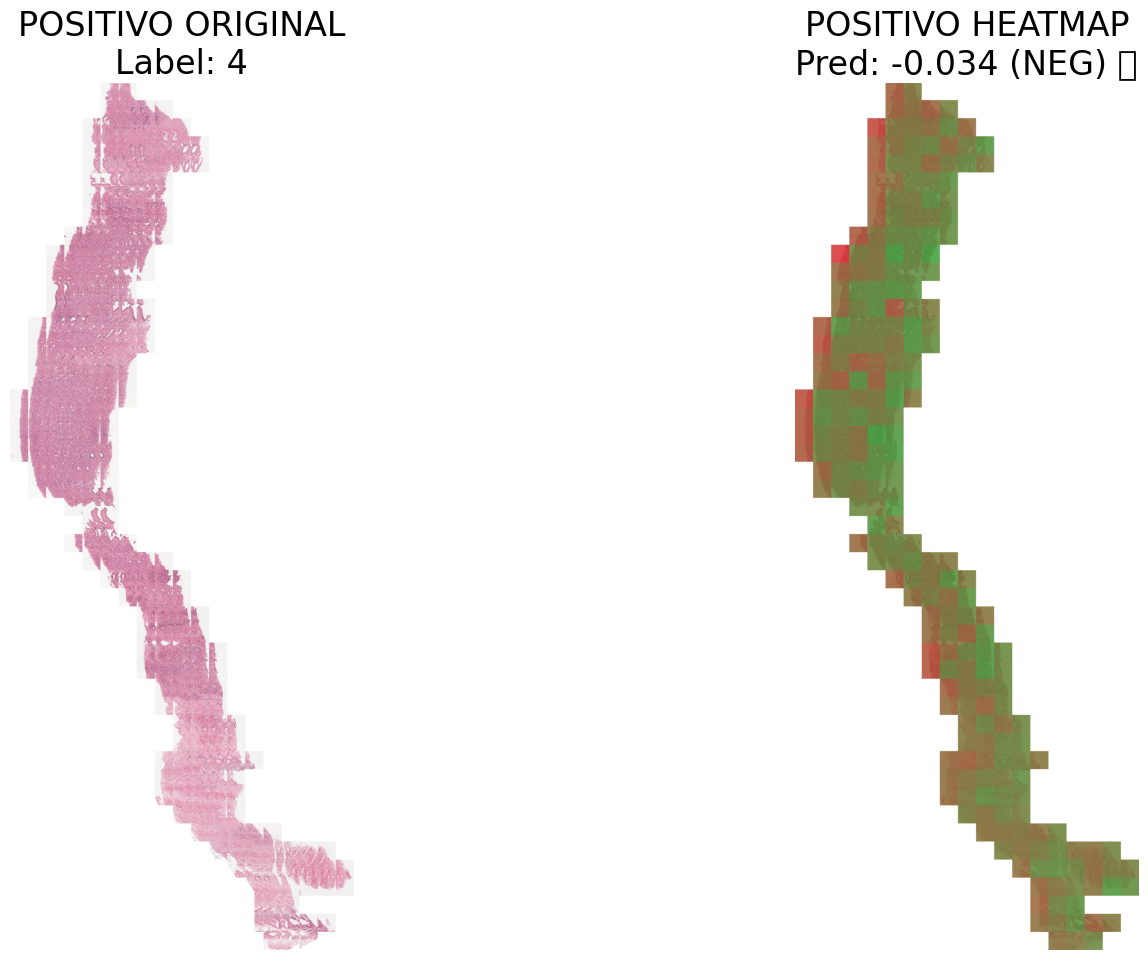

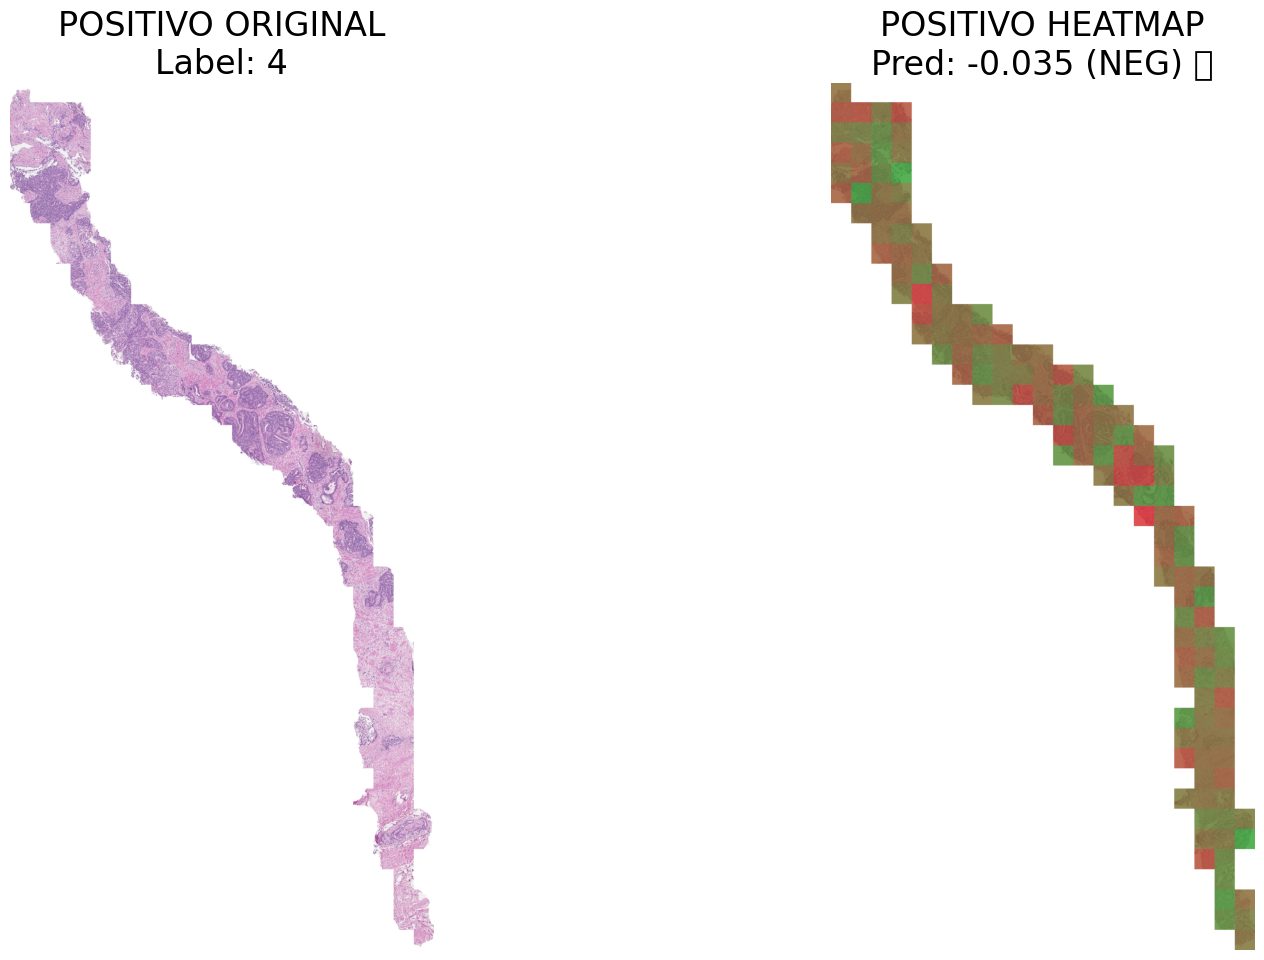

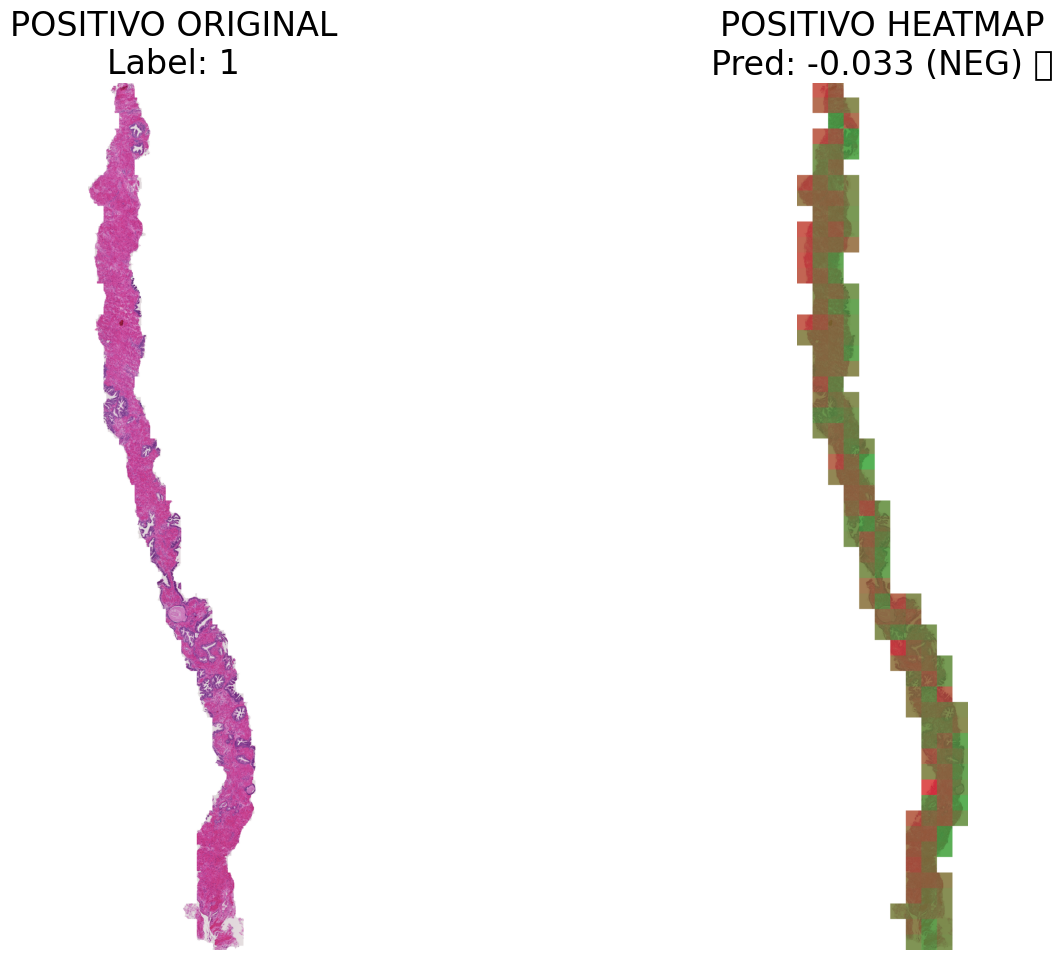

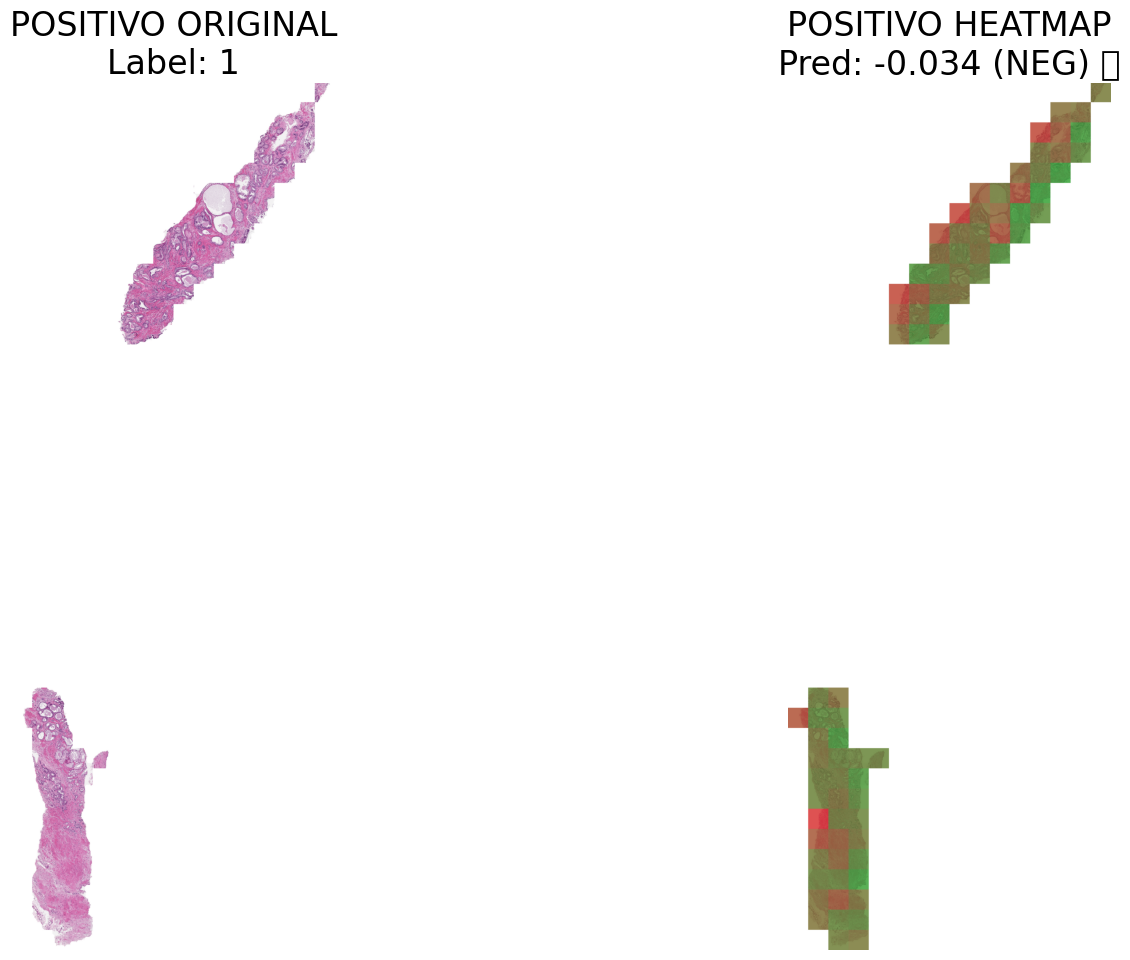

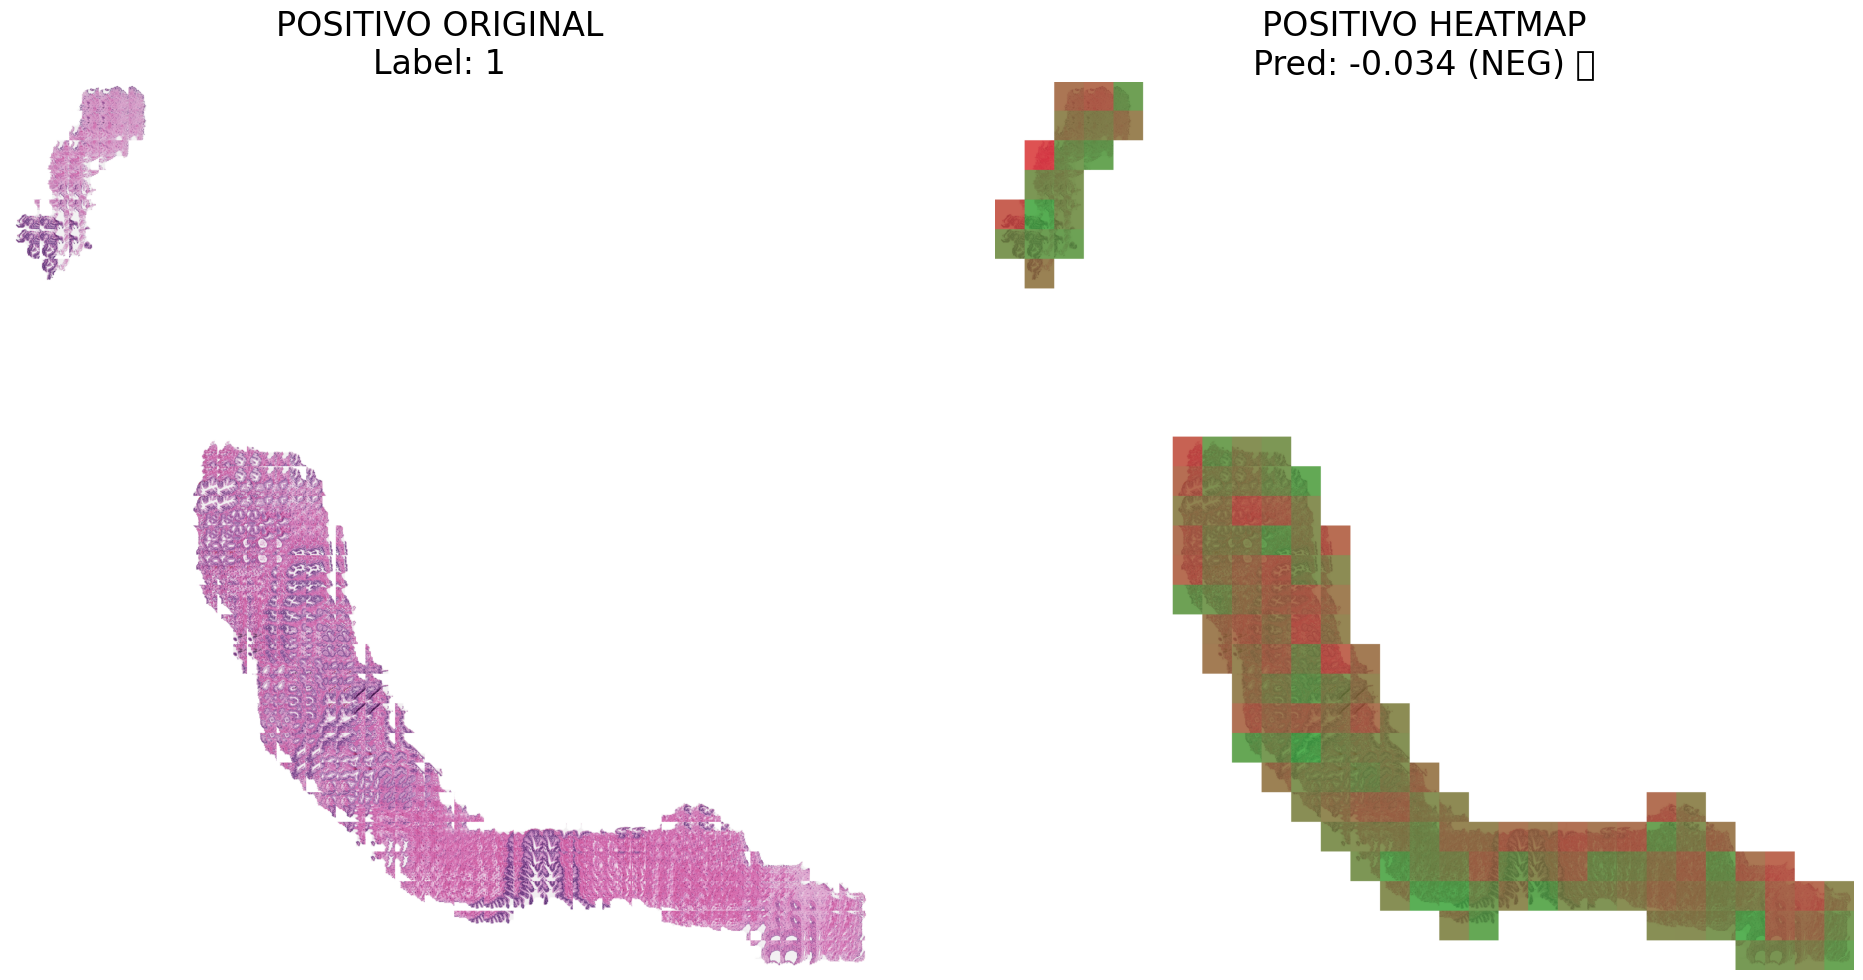

OutOfMemoryError: CUDA out of memory. Tried to allocate 416.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 353.75 MiB is free. Process 2397348 has 22.24 GiB memory in use. Including non-PyTorch memory, this process has 1.09 GiB memory in use. Of the allocated memory 438.24 MiB is allocated by PyTorch, and 373.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from scripts.model import MILModel
from scripts.plot_utils import plot_wsi_and_heatmap, normalize


# Añadir ruta si es necesario
sys.path.append('../')

# Parámetros globales
DATA_DIR          = '/data/datasets/PANDA/PANDA_original/original/train_images'
TRAIN_IMAGES_DIR  = os.path.join(DATA_DIR, 'train_images')
CSV_PATH          = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH        = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth'
SAVE              = False  # Desactivar guardado de figuras
PATCH_SIZE        = 512
RESIZE_SIZE       = 112    # para encajar con 4 poolings a 7×7
MAX_PATCHES       = 2000
FIGSIZE           = (10, 10)

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carga modelo una sola vez
model      = MILModel()
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

def analyze_and_plot(sample_row, title):
    """Extrae la WSI, calcula atención y dibuja original + heatmap."""
    wsi_id    = sample_row['image_id']
    label     = int(sample_row['isup_grade'])
    path      = os.path.join(TRAIN_IMAGES_DIR, f"{wsi_id}.tiff")
    
    # Extraer patches y canvas
    patches, coords_xy, psize = extract_patches_from_wsi(path, PATCH_SIZE, MAX_PATCHES)
    canvas, coords_rc         = create_canvas_from_patches(patches, coords_xy, psize, RESIZE_SIZE)
    
    # Preparar batch en gris
    t_list = []
    for p in patches:
        pr   = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
        gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
        pn   = gray.astype(np.float32) / 255.0
        t_list.append(torch.FloatTensor(pn).unsqueeze(0))
    batch = torch.stack(t_list).unsqueeze(0).to(device)  # (1, N, 1, H, W)
    
    # Forward atención
    with torch.no_grad():
        _, att = model(batch)
    w       = att.cpu().numpy().flatten()
    w_norm  = normalize(w)
    
    # Predicción
    pred_value = float(torch.sigmoid(_).cpu().numpy()) if MODEL_PATH.endswith('.pt') else float(_ .cpu().numpy())
    pred_cls   = (pred_value > 0.5)
    correct    = (pred_cls and label > 0) or (not pred_cls and label == 0)
    symbol     = "✅" if correct else "❌"
    
    # Mostrar original y heatmap
    fig, axes = plt.subplots(1, 2, figsize=(FIGSIZE[0]*2, FIGSIZE[1]))
    
    # Original
    axes[0].imshow(canvas)
    axes[0].set_title(f"{title} ORIGINAL\nLabel: {label}")
    axes[0].axis('off')
    
    # Heatmap
    plot_wsi_and_heatmap(
        axes[1], canvas,
        attval=w_norm,
        plot_patch_contour=False,
        size=RESIZE_SIZE,
        row_array=coords_rc[:,0],
        col_array=coords_rc[:,1],
        remove_axis=True
    )
    axes[1].set_title(f"{title} HEATMAP\nPred: {pred_value:.3f} ({'POS' if pred_cls else 'NEG'}) {symbol}")
    
    plt.tight_layout()
    if SAVE:
        plt.savefig(f"{title}_{wsi_id}.png", dpi=150)
    plt.show()
    
    return correct

# Cargar datos
df = pd.read_csv(CSV_PATH)

# Buscar y mostrar primer caso POSITIVO bien predicho
for _, row in df[df['isup_grade'] > 0].iterrows():
    if analyze_and_plot(row, "POSITIVO") :
        break

# Buscar y mostrar primer caso NEGATIVO bien predicho
for _, row in df[df['isup_grade'] == 0].iterrows():
    if analyze_and_plot(row, "NEGATIVO"):
        break
